Team $42$:

$$ Valerio\; Romano\; Cadura $$

$$ Muhammed\;Khair\;Hindawi $$

$$ Ferdinando\; Giordano $$

$$ Lorenzo\; Mainetti $$

#  **Garment Workers**

This dataset encapsulates crucial features of the apparel manufacturing workflow and employee productivity, compiled through manual data gathering, and subsequently verified by domain experts. Data collection spans multiple days throughout the year, and each observation (or row) manifests various properties associated with a dedicated worker group assigned to a specific task.

A brief overview and interpretation of the dataset attributes is provided as follows:

- `date`: This attribute records the date of data collection.
- `quarter`: This attribute divides the month into four quarters, indicating the specific portion of the month for each record.
- `department`: This feature indicates the department to which the concerned team is associated.
- `day`: This denotes the specific day of the week.
- `team`: This represents the team number associated with each record.
- `targeted_productivity`: This is the productivity goal established by the management for a particular team on a specific day.
- `smv`: This denotes the Standard Minute Value, i.e., the predetermined time allocated for a given task.
- `wip`: This refers to 'Work in Progress', quantifying the number of unfinished product items.
- `over_time`: This feature records the overtime duration in minutes incurred by each team.
- `idle_time`: This captures the duration during which the production was halted due to various factors.
- `idle_men`: This reflects the count of employees who remained unoccupied due to the aforementioned production interruptions.
- `no_of_workers`: This indicates the headcount in each team.
- `actual_productivity`: This records the actual productivity percentage accomplished by the workers, with values ranging between 0 and 1.

## Methodology

The methodology we followed to build and compare the models is as follows:

![Image description](diag1.jpg)

## **Loading the libraries**

In [2]:
# # plotting
library(dplyr)
library(ggplot2)
library(plotly)
library(gridExtra)
library(corrplot)
library(tidyr)
library(knitr)
# # imputation
library(caret)
library(missRanger)
# # modelling
library(glmnet)
library(mgcv)
library(randomForest)
library(pROC)
library(Metrics)
library(MLmetrics)
# # no warnings
options(warn = -1)

## **Loading the data**

In [3]:
# reading the data
garment_data <- read.csv("dataset/GarmentsWorkerProductivity.csv")

Upon scrutinizing the dataset table, it becomes clear that several intriguing attributes warrant discussion. The initial observation is that the `wip` column contains missing data, with only $691$ entries out of $1197$, signifying gaps in the information collected. Furthermore, columns such as `wip`, `over_time`, `incentive`, `idle_time`, `idle_men`, and `no_of_workers` exhibit maximum values that significantly exceed their respective $75_{th}$ percentiles. This observation implies the potential existence of outliers within the dataset. 

Interestingly, `targeted_productivity` shows a comparably narrow range, hinting at the presence of rigorous productivity objectives the factory endeavors to fulfill. A noteworthy level of overtime suggests that meeting production goals within standard working hours may be a challenge for the factory. The workforce size also demonstrates variability, ranging from $2$ to $89$, indicative of fluctuating employment based on production demands.

The aspects of `idle_time` and `idle_men` merit special attention as they reflect potential productivity issues within the factory operations. A relatively minimal average `idle_time`, coupled with a maximum of $300$ minutes, infers the possibility of production halts or other factors leading to wastage of time. Similarly, the maximum of $45$ `idle_men` suggests potential inefficiencies in workforce utilization or the production process. 

Notably, the dataset is free from duplicates and lacks any columns with uniform values across all entries. 

# **Data cleaning and preprocessing**

## **Check for missing values and handle them accordingly**.

In [4]:
# Check for missing values
missing_values <- colSums(is.na(garment_data))
print(missing_values)

                 date               quarter            department 
                    0                     0                     0 
                  day                  team targeted_productivity 
                    0                     0                     0 
                  smv                   wip             over_time 
                    0                   506                     0 
            incentive             idle_time              idle_men 
                    0                     0                     0 
   no_of_style_change         no_of_workers   actual_productivity 
                    0                     0                     0 


The analysis above reveals a substantial number of missing values in the `wip` column, a situation far from optimal. Discarding or eliminating these missing entries is unfeasible as it would result in a loss of approximately half of the dataset. Therefore, the most suitable strategy in this case would be imputation.

## Encode categorical variables

In [5]:
# Convert the categorical variables to factors using label encoding
garment_data_encoded <- garment_data

garment_data_encoded$day <- as.numeric(factor(garment_data_encoded$day))
garment_data_encoded$department <- as.numeric(factor(garment_data_encoded$department))
garment_data_encoded$quarter <- as.numeric(factor(garment_data_encoded$quarter))

## Convert date column to Date type

In [6]:
# Convert the 'date' column to Date type
garment_data_encoded$date <- as.Date(garment_data_encoded$date, format = "%m/%d/%Y")

## Imputation of missing values

In our investigation, we have chosen to employ multiple imputation methods, specifically MICE, median, and Random Forest imputation, to accurately fill the missing data. The rationale behind this approach is grounded in the principles of robustness and adaptability in statistical analysis.

- **MICE**: The Multiple Imputation by Chained Equations (MICE) method provides a comprehensive strategy that can account for the inherent uncertainty around missing values.
- **Median**: Median imputation is a relatively simple method, where the median value of a variable is used to replace its missing values. Median is chosen due to its robustness to outliers when compared to the mean.
- **Random Forest**: Random Forest imputation provides a robust approach for handling missing data by leveraging the strengths of Random Forest models. It captures complex non-linear relationships among variables and handles interactions between variables implicitly, which enables more accurate imputations. 

In [7]:
# Random Forest imputation

# Set a seed for reproducibility
set.seed(42)

# Apply RF imputation only to the wip column
garment_data_rf <- missRanger(garment_data_encoded, pmm.k = 5, variables = "wip", num.trees = 10)


Missing value imputation by random forests

  Variables to impute:		wip
  Variables used to impute:	date, quarter, department, day, team, targeted_productivity, smv, wip, over_time, incentive, idle_time, idle_men, no_of_style_change, no_of_workers, actual_productivity

iter 1
  |======================================================================| 100%
iter 2
  |======================================================================| 100%
iter 3
  |======================================================================| 100%


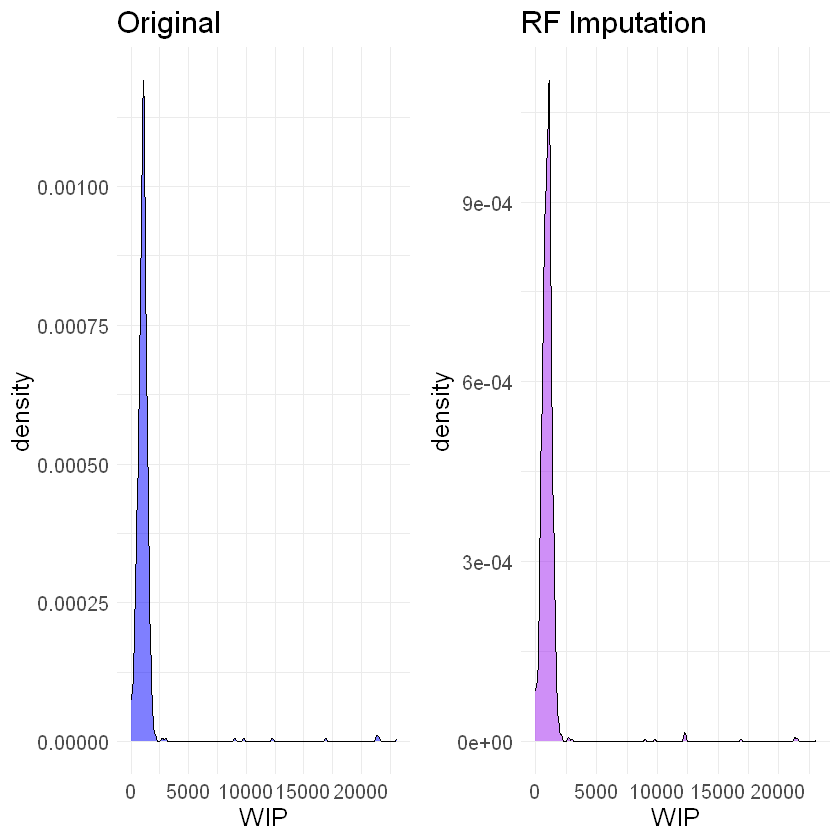

In [8]:
# Original dataset
p_original <- ggplot(garment_data_encoded, aes(x = wip)) +
  geom_density(fill = "blue", alpha = 0.5) +
  theme_minimal() +
  labs(title = "Original", x = "WIP") + theme(text = element_text(size = 15))

# RF imputation
p_rf <- ggplot(garment_data_rf, aes(x = wip)) +
  geom_density(fill = "purple", alpha = 0.5) +
  theme_minimal() +
  labs(title = "RF Imputation", x = "WIP") + theme(text = element_text(size = 15))

# Combine plots
grid.arrange(p_original,p_rf, ncol = 2, nrow = 1)

From our analysis, it becomes apparent that the Random Forest approach provides the most optimal imputation method for our dataset. Importantly, this technique maintains the integrity of the original data distribution, inducing minimal distortion.

## Checking for outliers

In the course of the data assessment, it is observed that the dataset contains outliers. Without more detailed context, it is challenging to determine if these outliers result from measurement or processing anomalies. Consequently, immediate outlier removal would be precipitous as these values could be representing significant extreme situations, such as mechanical failures or power disruptions.

These outliers likely reflect genuine variability in the data, thereby warranting their retention in the dataset. Additionally, it is crucial to conduct a comprehensive evaluation of these outliers to devise appropriate strategies for managing them.

Moreover, it is notable that some data distributions deviate from normality. However, as the analytical focus of this study does not involve linear models or algorithms that necessitate the assumption of normally distributed data, normalizing these skewed columns is not deemed essential. It should be acknowledged that transformation attempts, including the $BoxCox$ and $Log$ methods, were tested. However, these strategies failed to satisfy the requirements of the normality test.

Upon successful data cleaning, the study now proceeds to the exploratory phase, delving into the interrelationships among the dataset variables.

## Exploring the Variables

### Categorical Variables

#### Analyzing the Quarter column 

In [9]:
# create a frequency table
freq_table <- table(garment_data$quarter)

# transpose the table and format it as a neat way
freq_table_transposed <- t(freq_table)
kable(freq_table_transposed, align = rep("c", ncol(freq_table_transposed)), caption = "Quarterly Frequency Table")



Table: Quarterly Frequency Table

| Quarter1 | Quarter2 | Quarter3 | Quarter4 | Quarter5 |
|:--------:|:--------:|:--------:|:--------:|:--------:|
|   360    |   335    |   210    |   248    |    44    |

The data analysis reveals an intriguing aspect: there are $44$ instances designated as **Quarter 5**, which necessitates further investigation.

Upon closer scrutiny, it is discerned that the **Quarter 5** categorization invariably corresponds to the $29_{th}$ and $31_{st}$ dates in the date column. This correlation provides an explanation for the existence of $5$ quarters instead of the customary $4$ in the month of January. Such a phenomenon underlines the importance of detailed data exploration, which can uncover unique patterns and valuable insights. 

#### Analyzing the Department column

In [10]:
# create a frequency table
freq_table <- table(garment_data$department)

# transpose the table and format it as a neat way
freq_table_transposed <- t(freq_table)
kable(freq_table_transposed, align = rep("c", ncol(freq_table_transposed)), caption = "Department Frequency Table")



Table: Department Frequency Table

| finishing | sweing |
|:---------:|:------:|
|    506    |  691   |

### Univariate analysis of continuous variables

#### Analyzing the number of workers and incentive paid in each month 

In [11]:
garment_data$month_name <- format(as.Date(garment_data$date), "%B")

An interesting pattern emerges upon examining the workforce and incentive dynamics during the month of September. Despite a reduced workforce size, a high incentive was disbursed, implying an extended working duration beyond normal hours, which is a clear indication of overtime. This raises intriguing questions about the balance of labor and reward in this period.

#### Analyzing the Idle time spent by Teams

In [12]:
garment_data_temp <- garment_data
garment_data_temp$team <- factor(garment_data_temp$team, levels = 1:10)

Data highlights Team 8 and 7 as having the highest idle time. 

#### Analyzing the Idle men in Teams

This observation coincides with the finding that these two teams also record the highest number of `Idle_men`. This synchronicity warrants further investigation as it may imply underlying productivity issues within these teams. Understanding the reason for this correlation can offer valuable insights for managerial decisions and overall process optimization.

### Bivariate Analysis

#### Productivity Variation Across Days

A closer inspection of the daily productivity distribution reveals a relatively uniform mean productivity across all the days. An intriguing observation is the marginally elevated productivity level on Saturdays, registering an average of $0.75$. This could potentially be attributed to the rejuvenating effect of the preceding day, Friday, which is traditionally a day off for many. This illustrates the potential positive influence of regular breaks on work efficiency.

#### Team-Wise Productivity

Upon evaluating the productivity by teams, Team $1$ emerges as the most productive, closely followed by Team $3$. Conversely, Teams $7$ and $8$, along with Team $6$, register relatively lower productivity levels, echoing previous observations about their idleness. This recurring pattern necessitates a more detailed analysis of these teams' operational structure.

#### Incentives Dispensation Among Teams

Examining the incentive distribution, it's noteworthy that Team $9$ receives the highest average incentive, which initially appears counter-intuitive and invites a more careful inspection. On deeper analysis, it becomes apparent that an outlier in the **Finishing Department** is contributing to this observation. This finding illustrates how external anomalies can impact the data, making it essential to consider the broader context when interpreting results.

#### Overtime Distribution Across Departments

Investigating overtime hours reveals that the **Finishing Department**'s average overtime equates to a full day's work. Interestingly, this significant overtime does not correspond with any incentive compensation. On the contrary, the **Sewing Department** exhibits an average of four days' overtime. The lack of correlation between overtime and incentives in certain departments requires further exploration to understand the underlying factors influencing these operational decisions.

### Correlation Analysis

#### Correlation Matrix heatmap analysis to pick the variables that seem interesting

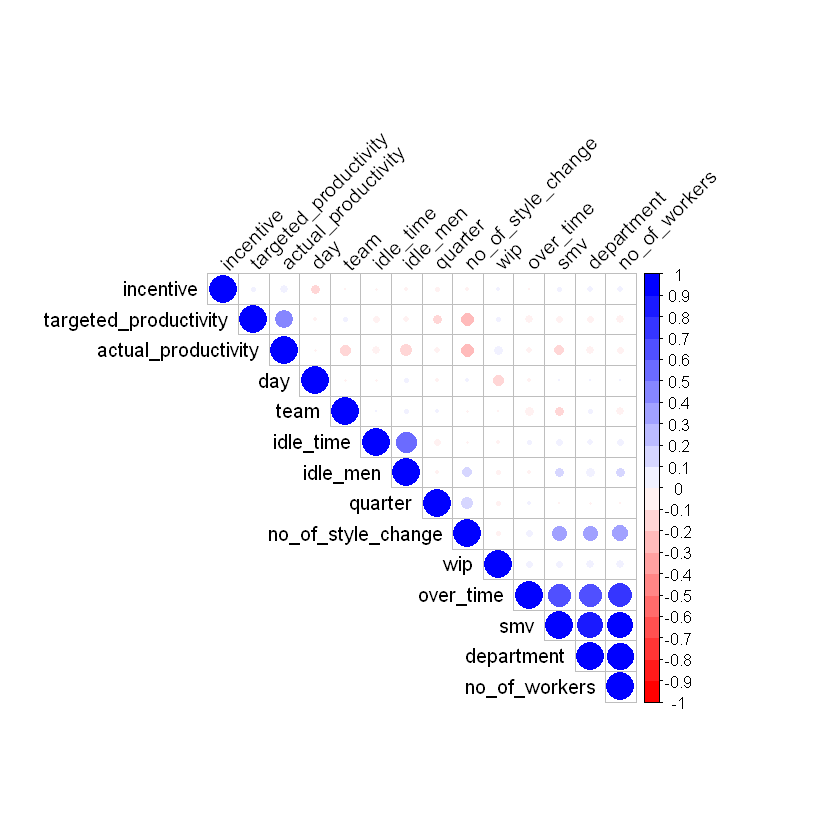

In [13]:
# Calculate correlation matrix
cor_matrix <- cor(garment_data_rf[, sapply(garment_data_rf, is.numeric)])

# Visualize the correlation matrix as a heatmap
corrplot(cor_matrix, type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45, col = colorRampPalette(c("red", "white", "blue"))(20))

#### Findings and Results 

An examination of the correlation matrix reveals some intriguing relationships between pairs of variables within the dataset:

- The variables `department` and `smv` exhibit a high positive correlation of $0.87$. This compelling association between the department and the Standard Minute Value (the allocated time for a task) warrants further investigation to understand the potential impact of this relationship on productivity.
- The relationship between `department` and `no_of_workers` is similarly strong, with a correlation coefficient of $0.94$. This high correlation suggests that the departmental size and the number of workers are closely intertwined, potentially due to inherent differences in department sizes and their respective staffing requirements.
- A positive correlation of $0.67$ exists between `over_time` and `smv`, indicating a relationship between overtime hours and the Standard Minute Value. It suggests that tasks with higher SMVs may necessitate longer overtime hours, a possibility that merits further exploration.
- The variables `over_time` and `no_of_workers` demonstrate a significant correlation of $0.73$, implying that teams with larger staff counts are likely to accrue more overtime. This relationship could offer insights into the dynamics of team sizes and their overtime demands.
- The variables `idle_time` and `idle_men` share a positive correlation of $0.56$. This correlation suggests a potential relationship between the amount of idle time and the number of idle workers. Such a relationship might indicate that an increase in idle workers could result in an aggregate increase in idle time.
- A moderate correlation of $0.32$ exists between `no_of_style_change` and `smv`, suggesting that tasks involving more style changes could be associated with higher SMVs.

The relationships between these pairs of variables could prove invaluable when constructing models with reduced dimensions. However, it's critical to bear in mind that correlation does not inherently denote causation. Therefore, these relationships demand further in-depth exploration to uncover the true nature of their interconnectedness.

**Statistical Associations with the Dependent Variable**

The correlation matrix, a fundamental statistical tool, provides valuable insights into the relationships between the variables in our dataset. One variable of particular interest is actual_productivity, the dependent variable in our study. Several independent variables exhibit noteworthy correlations with actual_productivity, either positively or negatively.

- `targeted_productivity`: This variable exhibits a positive correlation of $0.42$ with `actual_productivity`, the most substantial correlation observed in our dataset. This relationship suggests a tendency for `actual_productivity` to increase in tandem with targeted_productivity.

- `smv`: The Standard Minute Value (smv) demonstrates a negative correlation of -$0.12$ with `actual_productivity`. This relationship implies that actual_productivity may decrease as smv increases.

- `wip`: The Work in Progress (wip) variable shows a positive correlation of $0.20$ with `actual_productivity`. This correlation suggests that actual_productivity may increase as wip increases.

- `over_time`: The Overtime variable exhibits a negative correlation of -$0.05$ with `actual_productivity`. This relationship suggests a tendency for actual_productivity to decrease as over_time increases.

- `idle_men`: The Idle men variable demonstrates a negative correlation of -$0.18$ with `actual_productivity`. This correlation implies that actual_productivity may decrease as the number of idle_men increases.

- `no_of_style_change`: The No of style change variable shows a negative correlation of -$0.21$ with `actual_productivity`. This relationship suggests that actual_productivity may decrease as the no_of_style_change increases.

These variables, due to their significant correlations with `actual_productivity`, warrant further investigation in our model-building process. However, it is crucial to remember that correlation does not equate to causation. Therefore, these variables and their relationships with `actual_productivity` require additional exploration to fully understand their dynamics and potential causal mechanisms.

# **Task Details - Regression**

The primary objective of this study is to conduct a regression analysis on the target variable `actual_productivity` in the context of garment manufacturing enterprises. The dataset provided for this study comes with an example objective, however, the focus of this research has been tailored to meet the specific needs of decision-makers in the garment sector.

The global demand for garment items is substantial, and the ability of garment manufacturing enterprises to meet this demand is largely dependent on the performance of their workforce in terms of production and delivery. Consequently, monitoring, evaluating, and forecasting the productivity performance of factory work teams is of paramount importance to decision-makers in the garment industry. They are particularly interested in understanding the factors that significantly influence team productivity.

By conducting a regression analysis on the `actual_productivity` variable, this study aims to provide insights into the predictors that have a substantial impact on productivity. The findings of this research could be instrumental in informing strategies for improving productivity performance in garment manufacturing enterprises.

# **Lower Dimensional Modelling**

This part focuses on the investigation of relationships between select variables through the application of lower-dimensional models. The variables of interest include the `department`, Standard Minute Value (`smv`), `No_of_workers`, `Over_time`, and `Idle_time`. The models employed for this analysis include linear regression models with AIC and BIC step selection, decision trees, and regularization models such as Ridge, Lasso, and Elastic Net.

![Image description](diag2.jpg)

## Department and SMV

The first model explores the relationship between `department` and `smv`. The linear regression model, with **AIC step selection**, indicates a significant positive relationship between these variables, with the department explaining approximately $76.43$% of the variability in SMV. This relationship is further confirmed by the **decision tree** model.

## **Department and Number of Workers**

The second model investigates the relationship between `department` and `No_of_workers`. The linear regression model, with **BIC step selection**, suggests a significant positive relationship between these variables, with the department explaining approximately $88.24$% of the variability in the number of workers. Again the **decision tree** model confirms the relationship found.

## **Overtime and Number of Workers**

In [14]:
# Pair 5: over_time and no_of_workers
x1 <- cbind(1, garment_data_rf$over_time)
y1 <- garment_data_rf$no_of_workers

# Pair 6: idle_time and idle_men
x2 <- cbind(1, garment_data_rf$idle_time)
y2 <- garment_data_rf$idle_men

# Perform ridge, lasso, and elastic net regression for both pairs
set.seed(42)

# Pair 5
cv_ridge_1 <- cv.glmnet(x1, y1, alpha = 0)
cv_lasso_1 <- cv.glmnet(x1, y1, alpha = 1)
cv_elasticnet_1 <- cv.glmnet(x1, y1, alpha = 0.5)

# Pair 6
cv_ridge_2 <- cv.glmnet(x2, y2, alpha = 0)
cv_lasso_2 <- cv.glmnet(x2, y2, alpha = 1)
cv_elasticnet_2 <- cv.glmnet(x2, y2, alpha = 0.5)

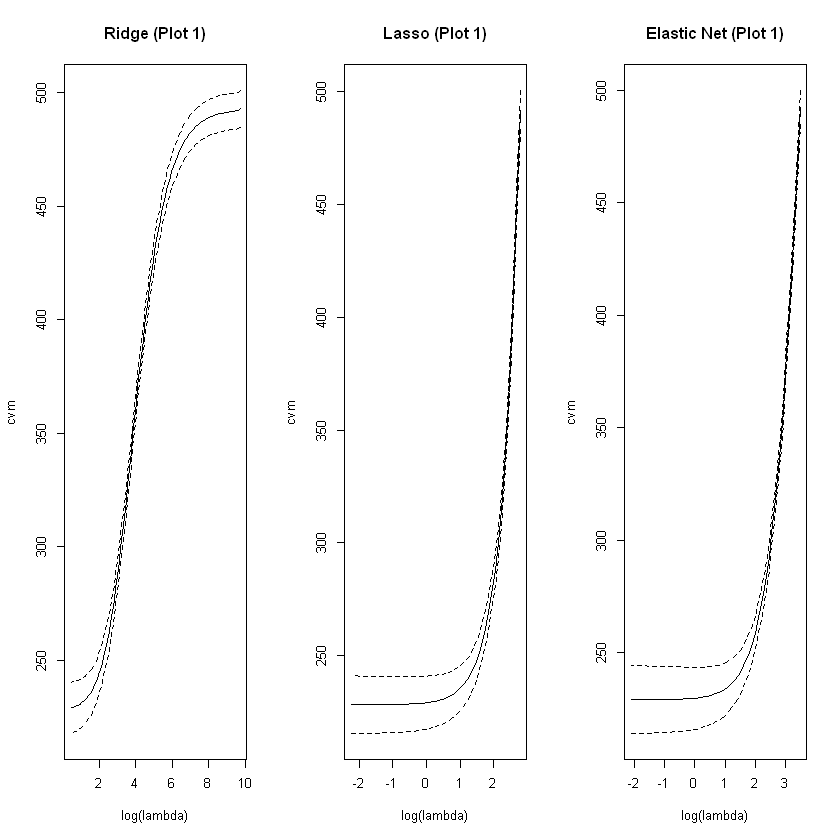

In [15]:
# Function to plot cv.glmnet results
plot_glmnet <- function(cv_model, model_name) {
  plot_data <- data.frame(lambda = cv_model$lambda, 
                          cvm = cv_model$cvm, 
                          cvsd = cv_model$cvsd, 
                          lower = cv_model$cvm - cv_model$cvsd,
                          upper = cv_model$cvm + cv_model$cvsd)
  
  plot(log(plot_data$lambda), plot_data$cvm, type = 'l', xlab = "log(lambda)", ylab = "cvm", main = model_name,
       ylim = range(plot_data$lower, plot_data$upper))
  lines(log(plot_data$lambda), plot_data$lower, lty = 2)
  lines(log(plot_data$lambda), plot_data$upper, lty = 2)
}

# Plot the ridge, lasso, and elastic net models for plot1
par(mfrow = c(1, 3)) # Set up the plotting area for three plots side by side
plot_glmnet(cv_ridge_1, "Ridge (Plot 1)")
plot_glmnet(cv_lasso_1, "Lasso (Plot 1)")
plot_glmnet(cv_elasticnet_1, "Elastic Net (Plot 1)")

The third model examines the relationship between `overtime` and the `No_of_workers`. The **Ridge**, **Lasso**, and **Elastic Net** regression models all indicate a consistent positive linear relationship between these variables, suggesting that as the number of workers increases, the amount of overtime also tends to increase.

## **Idle Time and Idle Men**

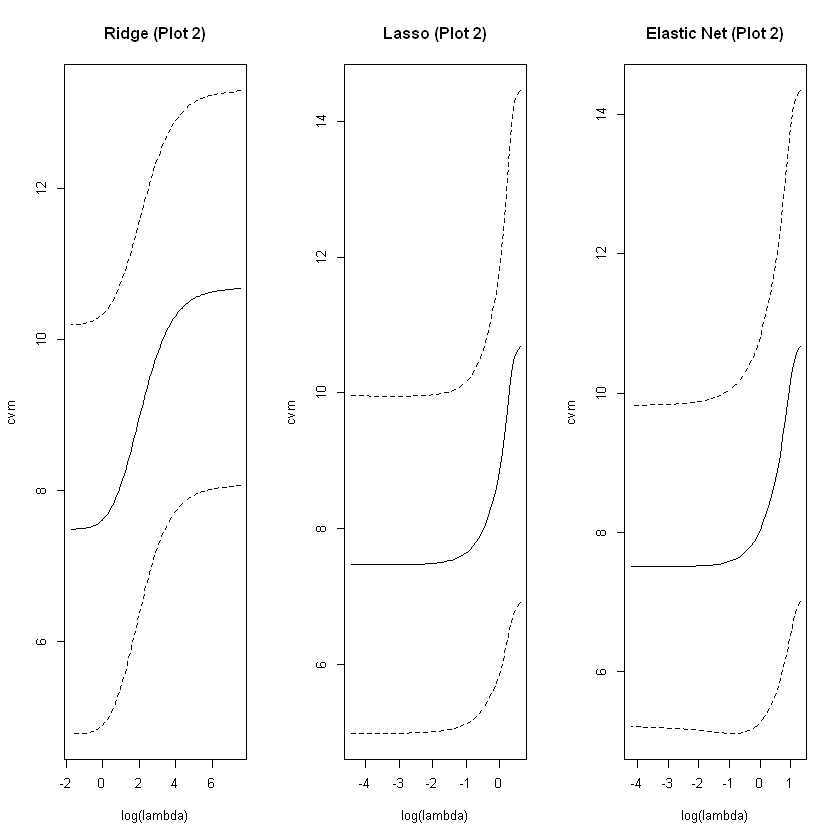

In [16]:
# Plot the ridge, lasso, and elastic net models for plot2
par(mfrow = c(1, 3)) # Set up the plotting area for three plots side by side
plot_glmnet(cv_ridge_2, "Ridge (Plot 2)")
plot_glmnet(cv_lasso_2, "Lasso (Plot 2)")
plot_glmnet(cv_elasticnet_2, "Elastic Net (Plot 2)")

The fourth model explores the relationship between `idle_time` and `idle_men`. The **Ridge**, **Lasso**, and **Elastic Net** regression models all suggest a consistent positive linear relationship between these variables, indicating that as the number of idle men increases, the amount of idle time also tends to increase.

## Conclusion

The lower-dimensional models provide valuable insights into the relationships between the selected variables. The results suggest that the department is a significant predictor of both the standard minute value and the number of workers. Additionally, there is a consistent positive linear relationship between overtime and the number of workers, as well as between idle time and idle men. These findings provide a foundation for further exploration in higher-dimensional models.


# **Building the full model**

In the pursuit of a robust model for predicting the `actual_productivity` in the garment manufacturing industry, we employed a three-pronged approach. The first approach involved the use of cross-validation, the second approach involved traditional model building and evaluation techniques with a train-validation-test split, and the third approach incorporated Principal Component Analysis ($PCA$) to reduce the dimensionality of the dataset before applying a train-validation-test split.

## Model Evaluation and Comparison - Cross Validation Approach

In the first approach, we utilized cross-validation to assess the performance of various models. Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called $k$ that refers to the number of groups that a given data sample is to be split into. This approach allowed us to use all of the data for both training and validation, providing a comprehensive overview of model performance.

**Note**: we used this approach here to find out which models might be good to use and compare closely, after that, we will pick the ones that performed good and test them again using a different method than only cross validation.

![Image description](diag3.jpg)

The models were compared based on their performance metrics. The analysis of **MSE**, **RMSE**, and **MAE** values allowed for the identification of models that performed better in predicting actual productivity. The XGBoost model demonstrated superior performance, followed by the Generalized Additive Model ($gam$), k-Nearest Neighbors ($knn$), and Elastic Net.

The XGBoost model emerged as the most accurate in predicting the actual productivity of teams in the garment industry, based on the evaluation metrics. This model's superior performance suggests its potential utility for further analysis and decision-making in the context of productivity prediction in the garment industry. 

**Note:** Feature selection techniques were applied, but no significant improvements were observed in the model performances.

## Splitting Data into Training, Validation, and Test sets.

In the second approach, we built and evaluated several models, including Linear, Elastic Net, Random Forest, Generalized Additive Models ($gam$), and k-Nearest Neighbors ($knn$). The models were evaluated based on three performance metrics: Mean Squared Error (**MSE**), Root Mean Squared Error (**RMSE**), and Mean Absolute Error (**MAE**).

In [17]:
# Step 1: Split the dataset into train, validation, and test sets
set.seed(42)
trainIndex <- createDataPartition(garment_data_rf$actual_productivity, p = 0.7, list = FALSE, times = 1)
trainData <- garment_data_rf[trainIndex,]
tempData <- garment_data_rf[-trainIndex,]

valIndex <- createDataPartition(tempData$actual_productivity, p = 0.5, list = FALSE, times = 1)
valData <- tempData[valIndex,]
testData <- tempData[-valIndex,]

# Define training control
control <- trainControl(method = "cv", number = 10)

In [18]:
# Elastic Net
model_elasticnet <- train(actual_productivity ~ ., data = trainData,
                          method = "glmnet",
                          trControl = control,
                          tuneLength = 10)

In [19]:
# Random Forest
model_rf <- train(actual_productivity ~ ., data = trainData,
                  method = "rf",
                  trControl = control,
                  tuneLength = 5)

In [20]:
# Generalized Additive Model (GAM)
model_gam <- train(actual_productivity ~ ., data = trainData,
                   method = "gam",
                   trControl = control,
                   tuneLength = 5)

In [21]:
# k-Nearest Neighbors (kNN)
model_knn <- train(actual_productivity ~ ., data = trainData,
                   method = "knn",
                   trControl = control,
                   tuneLength = 10)

In [22]:
# Step 4: Evaluate models on the validation set
models <- list(elasticnet = model_elasticnet, rf = model_rf, gam = model_gam, 
               knn = model_knn)

# Step 4: Evaluate models on the validation set
val_predictions <- lapply(models, function(model) predict(model, newdata = valData))

# Calculate performance metrics for each model
val_metrics <- lapply(val_predictions, function(pred) {
  actual <- valData$actual_productivity
  mse <- mean((pred - actual)^2)
  rmse <- sqrt(mse)
  mae <- mean(abs(pred - actual))
  data.frame(MSE = mse, RMSE = rmse, MAE = mae)
})

# Combine metrics into a single data frame
val_metrics_df <- do.call(rbind, val_metrics)

In [23]:
# Step 5: Pick the best model based on the lowest RMSE value
best_model_name <- rownames(val_metrics_df)[which.min(val_metrics_df$RMSE)]
cat("Best model:", best_model_name, "\n")

Best model: rf 


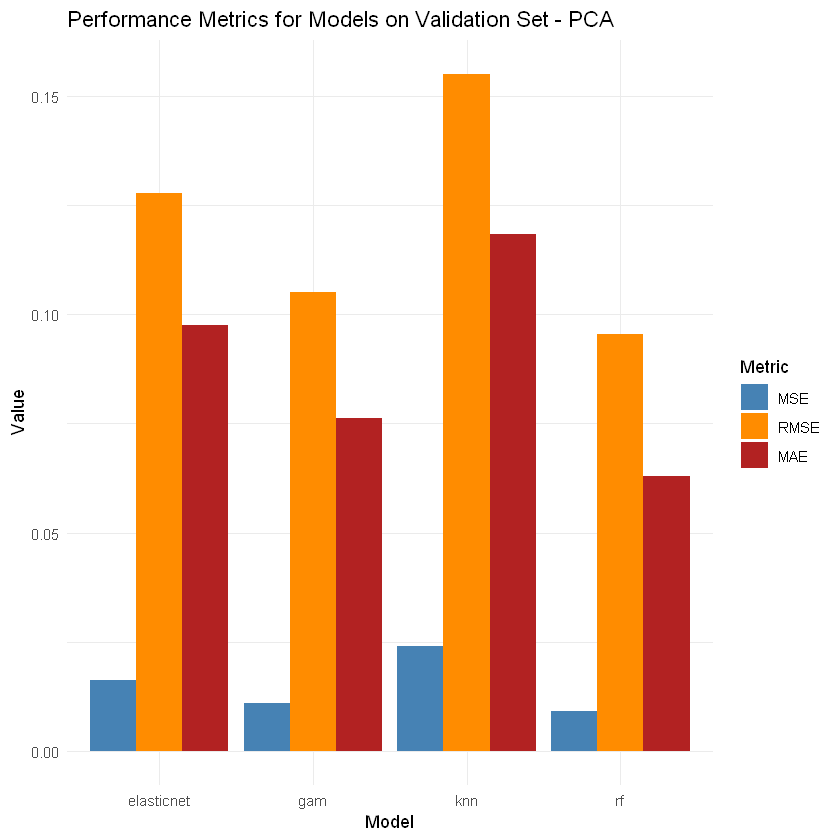

In [24]:
# Convert row names into a separate column
val_metrics_df$Model <- rownames(val_metrics_df)

# Reshape the data for plotting
val_metrics_long <- reshape2::melt(val_metrics_df, id.vars = "Model")

# Create a color scheme for the bars
colors <- c("steelblue", "darkorange", "firebrick")

# Create a bar plot using ggplot2
ggplot(val_metrics_long, aes(fill=variable, y=value, x=Model)) + 
  geom_bar(position="dodge", stat="identity") +
  scale_fill_manual(values=colors) +
  theme_minimal() +
  labs(x = "Model", y = "Value", fill = "Metric",
       title = "Performance Metrics for Models on Validation Set - PCA")

In [25]:
# Step 6: Evaluate the best model on the test set
best_predictions <- predict(models[[best_model_name]], newdata = testData)
testData$predictions <- best_predictions

# Calculate performance metrics
RMSE <- sqrt(mean((testData$actual_productivity - testData$predictions)^2))
R2 <- cor(testData$actual_productivity, testData$predictions)^2
MAE <- mean(abs(testData$actual_productivity - testData$predictions))
MSE <- mean((testData$actual_productivity - testData$predictions)^2)

cat("RMSE:", RMSE, "\n")
cat("R2:", R2, "\n")
cat("MAE:", MAE, "\n")
cat("MSE:", MSE, "\n")

RMSE: 0.09549829 
R2: 0.6793684 
MAE: 0.0623791 
MSE: 0.009119923 


### Model Evaluation Results On The Validation Set

| Model       | MSE        | RMSE       | MAE        |
|-------------|------------|------------|------------|
| Linear      | 0.01618840 | 0.12723364 | 0.09754545 |
| Elastic Net | 0.01642055 | 0.12814271 | 0.09757769 |
| Random Forest | 0.00963338 | 0.09814978 | 0.06499723 |
| GAM         | 0.01017540 | 0.10087318 | 0.07476922 |
| KNN         | 0.02403048 | 0.15501768 | 0.11712349 |

The Random Forest model emerged as the most accurate, with the lowest values across all three metrics on the validation set. 

When tested on an unseen test set, the model maintained its superior performance, explaining approximately $68$% of the variability in the data.

In conclusion, the **Random Forest** model appears to be the best model for predicting the actual productivity in this case.

## Principal Component Analysis $\rightarrow$ Splitting Data into Training, Validation, and Test sets.

In the third approach, we applied $PCA$ to the dataset before repeating the model building and evaluation process. $PCA$ is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance, and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors are an uncorrelated orthogonal basis set.

### Model Evaluation Results with PCA on The Validation Set

The table below shows the performance of different models on the validation set after applying Principal Component Analysis ($PCA$). The performance metrics used are Mean Squared Error (**MSE**), Root Mean Squared Error (**RMSE**), and Mean Absolute Error (**MAE**).

| Model       | MSE        | RMSE       | MAE        |
|-------------|------------|------------|------------|
| Linear      | 0.016188398 | 0.12723364 | 0.09754545 |
| Elastic Net | 0.016429914 | 0.12817923 | 0.09759515 |
| Random Forest | 0.009803949 | 0.09901489 | 0.06604709 |
| GAM         | 0.009630718 | 0.09813622 | 0.07321071 |
| KNN         | 0.023067429 | 0.15187965 | 0.11245924 |

After applying PCA, the Generalized Additive Model ($gam$) performed the best on the validation set. However, when tested on the test set, the Random Forest model, which was the second best on the validation set, outperformed the $gam$ model. This suggests that while the $gam$ model was able to capture more complex relationships in the validation set, the Random Forest model was more effective at generalizing to unseen data.

In conclusion, while the $gam$ model performed best on the validation set, the Random Forest model showed better generalization on the test set. This highlights the importance of evaluating models on a separate test set to assess their ability to generalize to unseen data.

## Final Thoughts

In conclusion, for this specific dataset and task, the Random Forest model without $PCA$ yielded the best performance on the test set, indicating superior generalization. This suggests that for this particular dataset, preserving the original features without dimensionality reduction was advantageous.

However, it is crucial to note that the optimal approach can vary depending on the specific dataset, task, and requirements. Both $PCA$ and non-$PCA$ methods have their respective advantages and can be suitable in different scenarios. $PCA$ can be particularly beneficial when dealing with high-dimensional data or when attempting to visualize complex patterns in the data. As always, it is a best practice to experiment with different approaches and select the one that best aligns with the specific needs and objectives of the study.

# Task 2 - Classification

In the context of this research, we propose a novel approach to transform the regression problem of predicting `actual_productivity`, which is a continuous variable $\in$ $[0 , 1]$ , into a binary classification problem. This transformation is achieved by setting a threshold of $0.8$ on the `actual_productivity`. If the `actual_productivity` is greater than or equal to $0.8$, it is classified as 1, indicating **high productivity**. Conversely, if the predicted productivity falls below this threshold, it is classified as $0$, indicating **lower productivity**.

In [26]:
# Compute the percentage of values >= 0.8 in the column "actual_productivity"
percentage_greater_equal <- mean(garment_data_rf$actual_productivity >= 0.8) * 100
# Print the percentage
cat("The percentage is:", percentage_greater_equal)

The percentage is: 47.28488

However, upon further consideration, we recognize that this approach may not be the most suitable for our research objective. The primary limitation is that it does not account for the variability in worker performance and task difficulty. It is plausible that the human resources department has hired workers with varying productivity levels, or that a general threshold is not applicable due to differences in tasks. Moreover, the percentage of observed values in the `actual_productivity` column that are greater than $0.8$ is less than $50$%, which raises concerns about the validity of the threshold approach.

## Another Approach

To address these limitations, we propose a more nuanced approach that considers the `targeted_productivity`, which is the productivity level set by the authority for a specific task, as a benchmark to determine whether a team has been productive. We suggest creating a new binary variable, `productive`, which will be set to $1$ if the `actual_productivity` exceeds the `targeted_productivity`, and $0$ otherwise. This approach acknowledges the differences in task difficulty, as the authority likely set the `targeted_productivity` with this consideration in mind.

\begin{equation}
productive = 
\left\{
    \begin{array}{lr}
        1, & \text{if } actual \geqslant targeted\\
        0, & \text{if } actual < targeted
    \end{array}
\right\}
\end{equation}

To implement this approach, we will create the new target column `productive` and subsequently remove the `actual_productivity` and `targeted_productivity` columns from the dataset. This adjustment aligns the dataset with our revised research objective.

![Image description](diag4.jpg)

In [27]:
# Create a new column "productive" based on the condition
garment_data_class <- dplyr::mutate(garment_data_rf, productive = ifelse(actual_productivity > targeted_productivity, 1, 0))

# Then remove the columns "actual_productivity" and "targeted_productivity"
garment_data_class <- dplyr::select(garment_data_class, -actual_productivity, -targeted_productivity)

cat("Let's see the percentage of teams that were productive in the dataset: ", mean(garment_data_class$productive))

Let's see the percentage of teams that were productive in the dataset:  0.7259816

In [28]:
# converting it into a factor
garment_data_class$productive <- as.factor(garment_data_class$productive)

Contrary to initial assumptions, $\approx$ $70$% of the workers are not underperforming. This finding was obtained by considering the productivity benchmarks set by the Authority. It appears that a majority of the workers are able to meet or exceed these productivity targets, suggesting a high level of compliance within the workforce.

This observation prompts us to reconsider our analytical approach. Given that a large proportion of workers are meeting productivity targets, it may be more appropriate to frame this as a classification problem rather than a regression problem. In other words, instead of predicting the exact productivity level, we could focus on predicting whether a worker is likely to meet the productivity target.

In the following sections, we will explore this classification approach and compare its results with those obtained from the regression approach.

In [29]:
# Step 1: Split the dataset into train, validation, and test sets
set.seed(42)
trainIndex <- createDataPartition(garment_data_class$productive, p = 0.7, list = FALSE, times = 1)
trainData <- garment_data_class[trainIndex,]
tempData <- garment_data_class[-trainIndex,]

valIndex <- createDataPartition(tempData$productive, p = 0.5, list = FALSE, times = 1)
valData <- tempData[valIndex,]
testData <- tempData[-valIndex,]

# Define training control
control <- trainControl(method = "cv", number = 10)

In [30]:
# Step 3: Train models

# Linear model with AIC
model_glm <- train(productive ~ ., data = trainData,
                   method = "glmStepAIC",
                   trControl = control,
                   family = binomial, # specify family = binomial for logistic regression
                   trace = FALSE) # trace = FALSE to minimize output during stepwise selection

In [31]:
# Elastic Net
model_elasticnet <- train(productive ~ ., data = trainData,
                          method = "glmnet",
                          trControl = control,
                          tuneLength = 10,
                          family = "binomial") 

In [32]:
# Random Forest
model_rf <- train(productive ~ ., data = trainData,
                  method = "rf",
                  trControl = control,
                  tuneLength = 5)

In [33]:
# Generalized Additive Model (GAM)
model_gam <- train(productive ~ ., data = trainData,
                   method = "gam",
                   trControl = control,
                   tuneLength = 5)

In [34]:
# k-Nearest Neighbors (kNN)
model_knn <- train(productive ~ ., data = trainData,
                   method = "knn",
                   trControl = control,
                   tuneLength = 10)

In [35]:
# Step 4: Evaluate models on the validation set
models <- list(linear = model_glm, elasticnet = model_elasticnet, rf = model_rf, gam = model_gam, 
               knn = model_knn)

val_predictions <- lapply(models, function(model) predict(model, newdata = valData, type = "prob"))

# Calculate performance metrics for each model
val_metrics <- suppressMessages(lapply(val_predictions, function(pred) {
  actual <- valData$productive
  pred_binary <- ifelse(pred[,2] > 0.5, 1, 0) # Convert predicted probabilities to binary predictions
  accuracy <- mean(pred_binary == actual)
  auc <- pROC::auc(pROC::roc(actual, pred[,2])) # Use probabilities for the positive class
  f1 <- F1_Score(y_pred = pred_binary, y_true = actual) # Use F1_Score from MLmetrics package
  data.frame(Accuracy = accuracy, AUC = auc, F1 = f1)
}))

# Combine metrics into a single data frame
val_metrics_df <- do.call(rbind, val_metrics)

In [36]:
# Step 5: Pick the best model based on the lowest RMSE value
best_model_name <- rownames(val_metrics_df)[which.max(val_metrics_df$AUC)]
cat("Best model:", best_model_name, "\n")

Best model: rf 


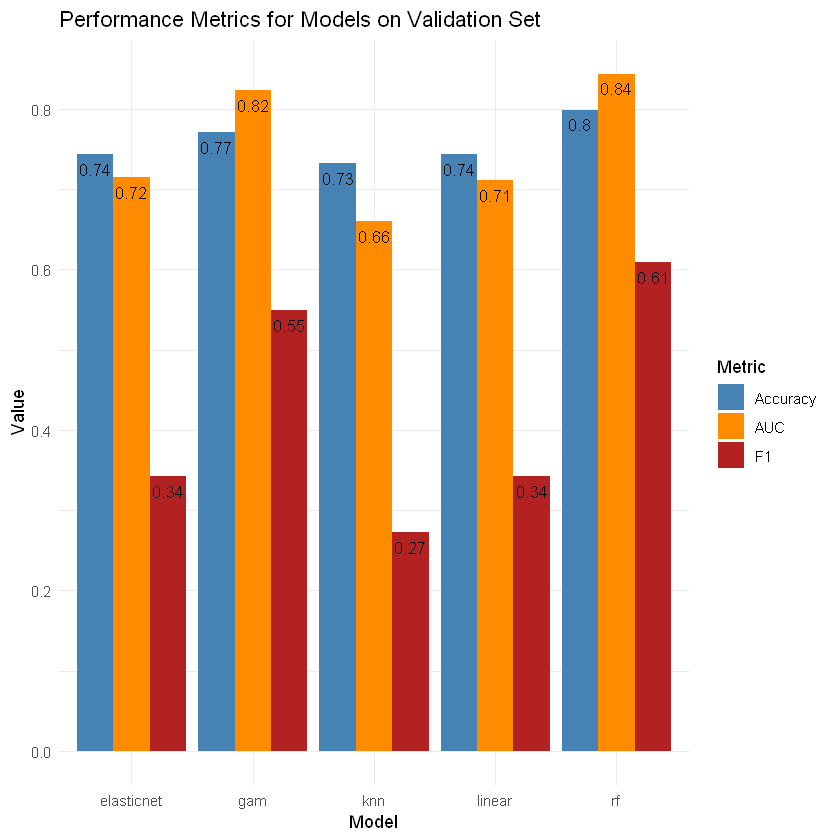

In [37]:
# Convert row names into a separate column
val_metrics_df$Model <- rownames(val_metrics_df)

# Reshape the data for plotting
val_metrics_long <- reshape2::melt(val_metrics_df, id.vars = "Model")

# Create a color scheme for the bars
colors <- c("steelblue", "darkorange", "firebrick")

# Create a bar plot using ggplot2
ggplot(val_metrics_long, aes(fill=variable, y=value, x=Model)) + 
  geom_bar(position="dodge", stat="identity") +
  scale_fill_manual(values=colors) +
  theme_minimal() +
  labs(x = "Model", y = "Value", fill = "Metric",
       title = "Performance Metrics for Models on Validation Set") +
  geom_text(aes(label=round(value, 2)), vjust=1.6, color="black", position = position_dodge(0.9), size=3.5)


In [38]:
# Step 6: Evaluate the best model on the test set
best_predictions <- predict(models[[best_model_name]], newdata = testData, type = "prob")

# Convert predicted probabilities to binary predictions
testData$predictions <- ifelse(best_predictions[,2] > 0.5, 1, 0)

# Calculate performance metrics
accuracy <- mean(testData$predictions == testData$productive)
auc <- pROC::auc(pROC::roc(testData$productive, best_predictions[,2]))
f1 <- F1_Score(y_pred = testData$predictions, y_true = testData$productive)

cat("Accuracy:", accuracy, "\n")
cat("AUC:", auc, "\n")
cat("F1:", f1, "\n")

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Accuracy: 0.7932961 
AUC: 0.8264521 
F1: 0.6105263 


## Performance Analysis on the Validation Set

In the context of this statistical analysis, we evaluated the performance of various classification models on the validation set. The performance metrics used for this evaluation were **Accuracy**, **Area Under the ROC Curve** ($AUC$), and $F1$ **Score**. These metrics provide a comprehensive assessment of the models' performance from different perspectives.

The table below presents the performance metrics for each model:

| Model | Accuracy | AUC | F1 Score |
|-------|----------|-----|----------|
| Linear | 0.754 | 0.746 | 0.346 |
| Elastic Net | 0.760 | 0.749 | 0.346 |
| Random Forest | 0.799 | 0.848 | 0.601 |
| GAM | 0.793 | 0.838 | 0.549 |
| KNN | 0.726 | 0.700 | 0.270 |

The Random Forest model exhibited superior performance in terms of $AUC$, a metric that evaluates the performance of binary classification models by considering both the true positive rate and the false positive rate. Meanwhile, the Generalized Additive Model ($gam$) achieved the highest $F1$ **Score**, a measure of a test's accuracy that considers both precision and recall.

Upon evaluating the Random Forest model on the test set, it achieved an **Accuracy** of $0.7932$, an $AUC$ of $0.8264$, and an $F1$ **Score** of $0.6105$. These results suggest that the model effectively generalizes to unseen data and balances precision and recall effectively.

## Comparison with Regression Results and Final Thoughts

Comparing these results with those of the regression task, it is evident that the classification approach provides a more straightforward interpretation of the results. While the regression models predicted the actual productivity as a continuous value, the classification models predict whether a team is productive or not, which may be more useful for decision-making purposes.

In terms of model performance, the Random Forest model also stood out in the regression task, indicating its robustness and versatility for different types of tasks. This suggests that the Random Forest model is a reliable choice for predicting team productivity in the garment industry, regardless of whether the task is regression or classification.